# Explore here

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import os
import joblib

## Paso 1: Carga del conjunto de datos

In [169]:
# Cargar conjunto de datos
url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
df = pd.read_csv(url)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [170]:
# Guardar en la carpeta data/raw
df.to_csv("../data/raw/df.csv", index = False)

## Paso 2: Realiza un EDA completo

In [171]:
# Conocer las dimensiones de los datos
df.shape

(768, 9)

In [172]:
# Obtener la información sobre tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


**Hallazgos**
- El conjunto de datos no contiene valores nulos.
- Todas las variables son numéricas.

In [173]:
# Ver lo número de valores únicos
df.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [174]:
# Comprobar si hay filas duplicadas
df.duplicated().sum()

np.int64(0)

In [175]:
# Conteo de valores únicos en la variable objetivo Outcome
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

Voy revisar cuántos ceros hay en algunas columnas donde sospecho que un valor de cero podría representar datos ausentes o erróneos. Por ejemplo, una persona no puede tener una presión arterial igual a 0. 

In [176]:
# Ver cuántos ceros hay
columnas_con_ceros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columnas_con_ceros].isin([0]).sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

**Justificación del reemplazo de ceros por la mediana segmentada por clase**

En el dataset hay muchos valores iguales a 0 que, desde el punto de vista médico, no representan valores válidos, sino datos faltantes o errores de registro.

Como el conjunto de datos no es muy grande, he decidido no eliminar estos registros, sino reemplazar los ceros por la mediana. Para evitar sesgos, he optado por una estrategia: reemplazar los ceros por la mediana correspondiente al grupo de Outcome (0 = no diabético, 1 = diabético). De este modo, se preserva la información relevante que puede aportar cada variable para predecir la enfermedad.

In [177]:
# Reemplazo de ceros en columnas numéricas por la mediana según el grupo de Outcome (diabético o no)

# Columnas que no deberían tener ceros (biológicamente no tiene sentido que esos valores sean 0)
columnas_con_ceros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Reemplazo de ceros: uso la mediana de cada clase por separado (diabéticos y no diabéticos)
for col in columnas_con_ceros:
    for clase in [0, 1]:  # 0 = no diabético, 1 = diabético
        # Calcular la mediana de los valores no nulos para esa clase
        mediana = df.loc[(df[col] != 0) & (df['Outcome'] == clase), col].median()
        
        # Reemplazar los ceros solo en esa clase con la mediana correspondiente
        df.loc[(df[col] == 0) & (df['Outcome'] == clase), col] = mediana

/tmp/ipykernel_880/1117144029.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '74.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[col] == 0) & (df['Outcome'] == clase), col] = mediana
/tmp/ipykernel_880/1117144029.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '102.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[col] == 0) & (df['Outcome'] == clase), col] = mediana


In [178]:
df[columnas_con_ceros].isin([0]).sum()

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 54.1 KB


## Paso 3: Construye un modelo de árbol de decisión

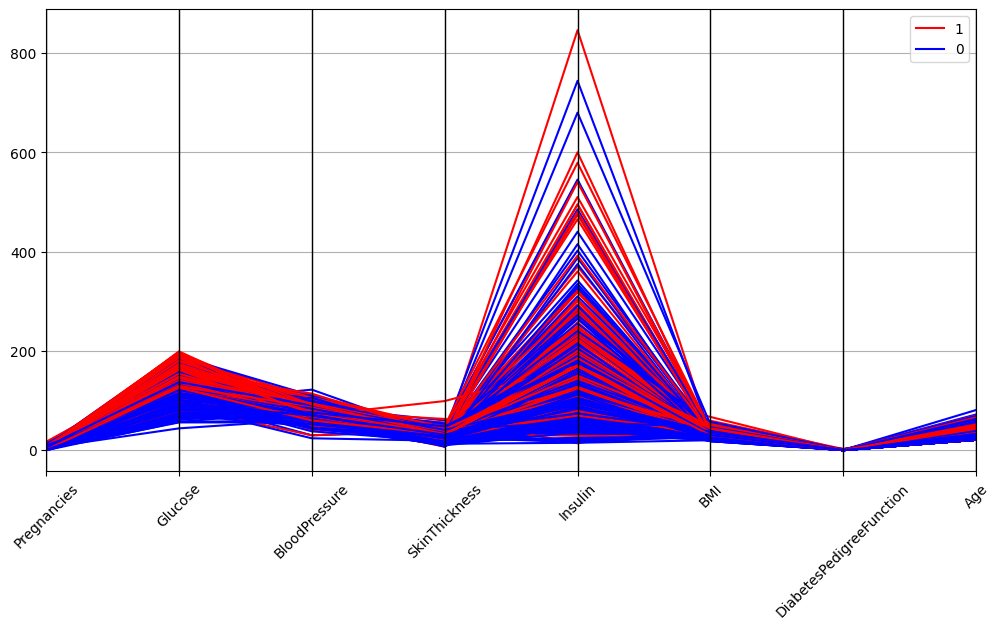

In [180]:
# Visualizamos la relación entre las características de nuestro dataset
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

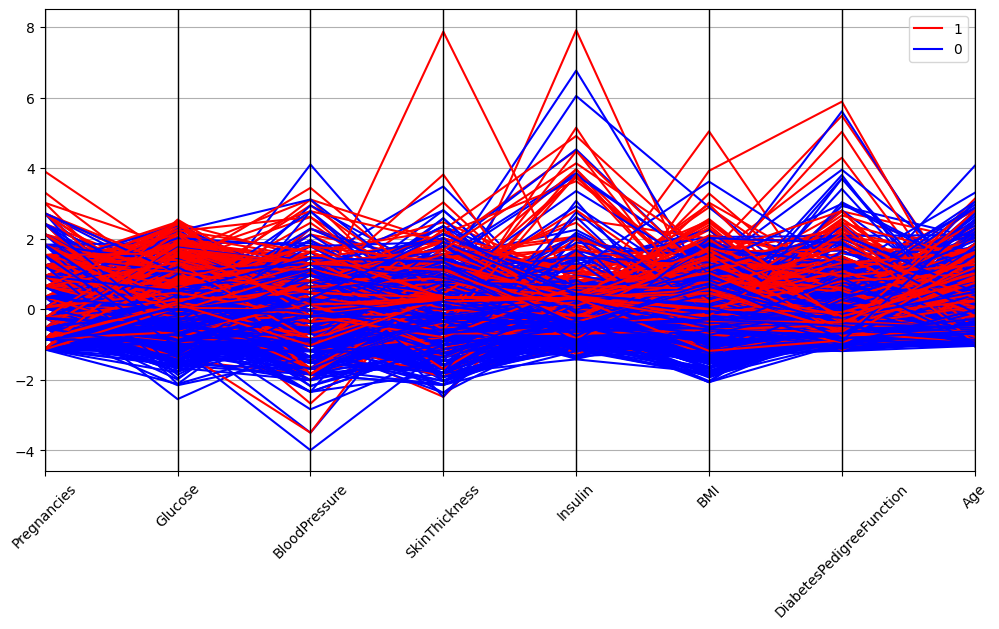

In [181]:
# Visualizamos la relación entre las características de nuestro dataset escalado
data_sc = pd.DataFrame(data=StandardScaler().fit_transform(df.drop(['Outcome'], axis=1)), columns=df.columns[:-1])
data_sc['Outcome'] = df.Outcome
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(data_sc, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

In [182]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Outcome'],axis=1), df['Outcome'], test_size=0.2, random_state=42)

In [183]:
X_train.shape

(614, 8)

In [184]:
X_test.shape

(154, 8)

In [185]:
# Guardar los datasets procesados
os.makedirs('data/processed', exist_ok=True)
X_train.to_csv('data/processed/X_train.csv', index=False)
X_test.to_csv('data/processed/X_test.csv', index=False)
y_train.to_csv('data/processed/y_train.csv', index=False)
y_test.to_csv('data/processed/y_test.csv', index=False)

## Árbol de decisión

In [186]:
# Arbol de decisión simple
simple_tree = DecisionTreeClassifier(max_depth=3, max_features=X_train.shape[1]//2, min_samples_leaf=20, min_samples_split=30, random_state=42)
simple_tree.fit(X_train, y_train)

# Arbol de decisión complejo
complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42)
complex_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=100, random_state=42)

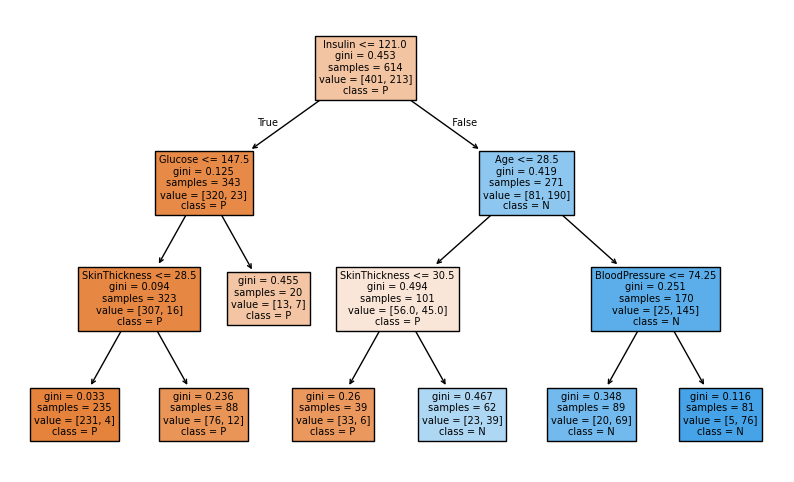

In [187]:
# Visualiza el árbol de decisión simple gráficamente
plt.figure(figsize=(10, 6))
plot_tree(simple_tree, feature_names=X_train.columns, class_names=['P','N'], filled=True)
plt.show()

In [188]:
X_train[(X_train['Insulin'] < 121.0) & (X_train['Glucose'] <= 147.5)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
60,2,84,70.0,27,102.5,30.1,0.304,21
346,1,139,46.0,19,83.0,28.7,0.654,22
340,1,130,70.0,13,105.0,25.9,0.472,22
90,1,80,55.0,27,102.5,19.1,0.258,21
377,1,87,60.0,37,75.0,37.2,0.509,22
...,...,...,...,...,...,...,...,...
330,8,118,72.0,19,102.5,23.1,1.476,46
466,0,74,52.0,10,36.0,27.8,0.269,22
121,6,111,64.0,39,102.5,34.2,0.260,24
106,1,96,122.0,27,102.5,22.4,0.207,27


In [189]:
# Interpretación del árbol simple en texto plano
text_representation = export_text(simple_tree, feature_names=list(X_train.columns))
print(text_representation)

|--- Insulin <= 121.00
|   |--- Glucose <= 147.50
|   |   |--- SkinThickness <= 28.50
|   |   |   |--- class: 0
|   |   |--- SkinThickness >  28.50
|   |   |   |--- class: 0
|   |--- Glucose >  147.50
|   |   |--- class: 0
|--- Insulin >  121.00
|   |--- Age <= 28.50
|   |   |--- SkinThickness <= 30.50
|   |   |   |--- class: 0
|   |   |--- SkinThickness >  30.50
|   |   |   |--- class: 1
|   |--- Age >  28.50
|   |   |--- BloodPressure <= 74.25
|   |   |   |--- class: 1
|   |   |--- BloodPressure >  74.25
|   |   |   |--- class: 1



**Hallazgos**

- Insulin es la variable más relevante:

    Si ≤ 121, el modelo predice mayoritariamente clase 0 (no diabético).

    Si > 121, el riesgo de diabetes aumenta.

- Glucose elevada (>147.5) no cambia la predicción si la insulina es baja.

    Sugiere que la glucosa alta sin insulina alta no es suficiente para predecir diabetes.

- SkinThickness y Age ayudan a refinar la predicción cuando la insulina es alta.

- En personas jóvenes con insulina alta, un grosor de piel mayor a 30.5 indica mayor probabilidad de diabetes.

- En personas mayores con insulina alta, una presión arterial baja (≤ 74.25) también se asocia con diabetes.

In [190]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

## Predicciones de los dos árboles

In [191]:
# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex = complex_tree.predict(X_train)
test_pred_complex = complex_tree.predict(X_test)

# Evaluar el modelo simple en entrenamiento y prueba
train_pred_simple = simple_tree.predict(X_train)
test_pred_simple = simple_tree.predict(X_test)

## Métricas

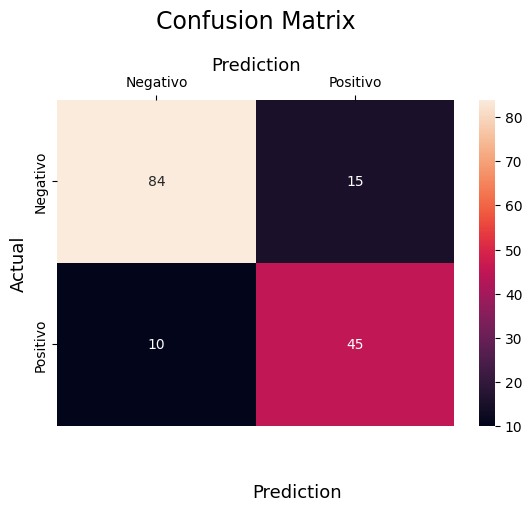

In [192]:
# Matriz de confusión
cm = confusion_matrix(y_test,test_pred_complex)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Negativo','Positivo'],
            yticklabels=['Negativo','Positivo'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

**Interpretación**

- 84 Verdaderos negativos: el modelo predijo no diabético (0) y era correcto.

- 15 Falsos positivos: el modelo predijo diabético (1), pero en realidad no lo era.

- 10 Falsos negativos: el modelo predijo no diabético (0), pero en realidad sí lo era.

- 45 Verdaderos positivos: el modelo predijo diabético (1) y era correcto.

**Conclusión:** El modelo detecta bien los casos de diabetes (recall alto), mantiene una buena precisión y muestra un desempeño general equilibrado.

In [193]:
# Métricas del modelo complejo
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.00,1.000000,1.000000
Test,0.837662,0.782609,0.833333,0.75,0.818182,0.848485
Diferencia,0.162338,0.217391,0.166667,0.25,0.181818,0.151515


In [194]:
# Métricas del modelo simple
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.874593,0.826966,0.872075,0.793103,0.863850,0.880299
Test,0.850649,0.806723,0.855556,0.750000,0.872727,0.838384
Diferencia,0.023943,0.020244,0.016519,0.043103,-0.008878,0.041915


**Hallazgos**

- Modelo complejo

Sobreentrenamiento evidente: desempeño perfecto en entrenamiento (accuracy = 1.0) y caída notable en test.

Diferencias entre train y test, especialmente en F1, precisión y ACU.

- Modelo simple

Rendimiento más equilibrado entre train y test.

Diferencias mínimas, lo que indica mejor generalización.

**Conclusión** 
- El modelo simple es preferible: generaliza mejor, tiene menos riesgo de sobreajuste y mantiene un rendimiento sólido en test.

- El modelo complejo sobreajusta y, aunque parece ideal en entrenamiento, pierde confiabilidad en datos nuevos.

In [195]:
simple_tree.predict_proba(X_train)

array([[0.98297872, 0.01702128],
       [0.0617284 , 0.9382716 ],
       [0.98297872, 0.01702128],
       ...,
       [0.0617284 , 0.9382716 ],
       [0.0617284 , 0.9382716 ],
       [0.98297872, 0.01702128]], shape=(614, 2))

## Paso 4: Optimiza el modelo

In [196]:
# Instancia del modelo
dtc = DecisionTreeClassifier(random_state=42)

In [197]:
# Definir hiperparametros
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10, None], # profundidad máxima del árbol
    'min_samples_split': [2, 5, 10], # mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4] # mínimo de muestras por hoja
}

In [198]:
# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=1)

In [199]:
# Ver los mejores resultados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor score de F1 en validación:")
print(grid_search.best_score_)

Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}

Mejor score de F1 en validación:
0.8152091631492381


In [200]:
# Modelo decision tree con parametros optimizados
best_dtc = grid_search.best_estimator_
best_dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2,
                       min_samples_split=5, random_state=42)

In [201]:
# Predicciones
y_train_pred = best_dtc.predict(X_train)
y_test_pred = best_dtc.predict(X_test)

## Evaluacion del modelo

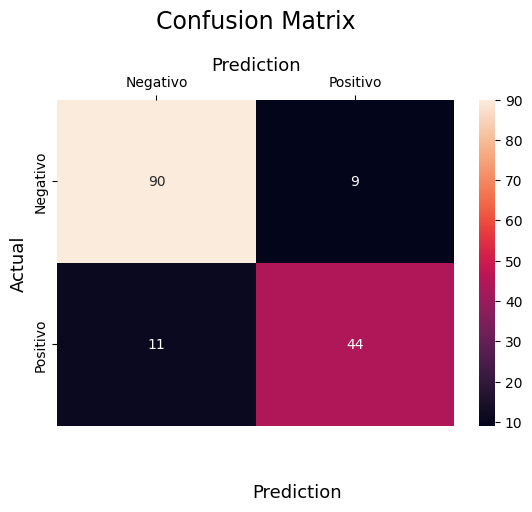

In [202]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Negativo','Positivo'],
            yticklabels=['Negativo','Positivo'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [203]:
# Calculo el accuract en train y test
train_acc = accuracy_score(y_true=y_train, y_pred=y_train_pred)
test_acc = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("Accuracy en train:", round(train_acc, 3))
print("Accuracy en test :", round(test_acc, 3))

Accuracy en train: 0.938
Accuracy en test : 0.87


In [204]:
# Reporte de clasificación
print("\nReporte en test:")
print(classification_report(y_test, y_test_pred, target_names=["Negativo", "Positivo"]))


Reporte en test:
              precision    recall  f1-score   support

    Negativo       0.89      0.91      0.90        99
    Positivo       0.83      0.80      0.81        55

    accuracy                           0.87       154
   macro avg       0.86      0.85      0.86       154
weighted avg       0.87      0.87      0.87       154



**Hallazgos**

- El modelo alcanzó 87 % de accuracy en test, mostrando buena capacidad predictiva.
- Detecta bien ambas clases: 91 % de recall en no diabéticos y 80 % en diabéticos.
- Sin sobreajuste evidente - diferencia moderada entre train (93.8 %) y test (87 %).

**Conclusiones**
- El modelo optimizado mejora la precisión global y reduce el sobreajuste, siendo más fiable para predecir nuevos casos.

## Paso 5: Guarda el modelo

In [205]:
# Crear carpeta
os.makedirs('artifacts', exist_ok=True)

# Guardar modelo optimizado
joblib.dump(best_dtc, 'artifacts/decision_tree_optimized.pkl')


['artifacts/decision_tree_optimized.pkl']